In [ ]:
import numpy as np
import pandas as pd
import os
import pickle

In [15]:
import rasterio
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.features import geometry_mask

import geopandas as gpd

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


In [ ]:
import matplotlib.pyplot as plt
import shap
import lime

# Machine learning model

Check relationship between multiple dataset, identify main drivers for land cover type change.

## 1 Train Test Split

In [17]:
prepared_df = pd.read_csv('For_dashboard/prepared_df.csv', index_col=0)
prepared_df

,year,lat,lon,gpp,land,pop,popdens,rainfall
0,2010,0,0,NaN,NaN,NaN,0.597434,NaN
1,2010,0,1,NaN,NaN,NaN,0.596992,NaN
2,2010,0,2,NaN,NaN,NaN,0.595006,NaN
3,2010,0,3,NaN,NaN,NaN,0.593069,NaN
4,2010,0,4,NaN,NaN,NaN,0.591274,NaN
...,...,...,...,...,...,...,...,...
3125410,2023,766,452,1378.0,10.0,NaN,NaN,NaN
3125411,2023,767,449,2433.0,10.0,NaN,NaN,NaN
3125412,2023,767,450,2450.0,10.0,NaN,NaN,NaN
3125413,2023,767,451,2079.0,10.0,NaN,NaN,NaN


In [18]:
df_cleaned = prepared_df.dropna()
df_cleaned

,year,lat,lon,gpp,land,pop,popdens,rainfall
99795,2010,176,392,627.0,16.0,2.201975,2.201975,145.020981
99796,2010,176,393,633.0,10.0,2.400784,2.400784,144.054916
106553,2010,188,370,695.0,16.0,3.405080,3.405080,172.263367
107115,2010,189,367,1437.0,10.0,3.903843,3.903843,173.341553
108246,2010,191,368,1492.0,10.0,5.662525,5.662525,174.425308
...,...,...,...,...,...,...,...,...
2606975,2020,758,451,3222.0,10.0,36.147739,36.147739,664.989441
2606976,2020,758,452,3095.0,10.0,38.170673,38.170673,665.641907
2606977,2020,758,453,3398.0,10.0,40.054672,40.054672,666.294373
2606978,2020,758,454,3329.0,10.0,43.492802,43.492802,666.946899


In [19]:
X = df_cleaned[['lat','lon','gpp','pop','rainfall']]
y = df_cleaned['land']

In [20]:
# Convert 'land' into categorical using LabelEncoder
label_encoder = LabelEncoder()
y_categorical = label_encoder.fit_transform(y)

In [21]:
y_categorical

# label mapping
label_mapping = dict(zip(y_categorical, y))
print("Mapping from encoded label to original y:")
print(label_mapping)

# mapping from modeling categories to actual land types 
land_types = {
    16: 'Barren_or_sparsely_vegetated',
    7: 'Open_shrublands',
    10: 'Grasslands',
    12: 'Croplands',
    13: 'Urban_and_built_up'
    }
y_land_types = {label: land_types.get(original_y, 'Unknown') for label, original_y in label_mapping.items()}
y_land_types_sorted = dict(sorted(y_land_types.items()))
print("Mapping from y_categorical to land types:")
print(y_land_types_sorted)

Mapping from encoded label to original y:
{4: 16.0, 1: 10.0, 0: 7.0, 3: 13.0, 2: 12.0}
Mapping from y_categorical to land types:
{0: 'Open_shrublands', 1: 'Grasslands', 2: 'Croplands', 3: 'Urban_and_built_up', 4: 'Barren_or_sparsely_vegetated'}


**Description of different land type:**

- **Open shrublands:** Dominated by woody perennials (1-2m height) 10-60% cover.

- **Grasslands:** Dominated by herbaceous annuals (<2m).

- **Croplands:** At least 60% of area is cultivated cropland.

- **Urban and built up:** At least 30% impervious surface area including building materials, asphalt, and vehicles.

- **Barren or sparsely vegetated:** At least 60% of area is non-vegetated barren (sand, rock, soil) areas with less than 10% vegetation.

In [22]:
# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

## 2 Modeling

### 2.1 Logistic Regression

In [23]:
# Initialize and train the linear regression model
lr = LogisticRegression(max_iter=100)
lr.fit(X_train, y_train)

/Users/sishanyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [24]:
lr_y_pred = lr.predict(X_test)

In [25]:
lr_report = classification_report(y_test, lr_y_pred)
print(lr_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       501
           1       0.99      1.00      0.99     61990
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00       253

    accuracy                           0.99     62751
   macro avg       0.20      0.20      0.20     62751
weighted avg       0.98      0.99      0.98     62751



/Users/sishanyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sishanyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sishanyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

### 2.2 Randon Forest

In [26]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [27]:
# Make predictions on the test set
rf_y_pred = rf.predict(X_test)

# Evaluate the model
rf_report = classification_report(y_test, rf_y_pred)

# Print the results
print("Classification Report:\n", rf_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.24      0.37       501
           1       0.99      1.00      0.99     61990
           2       0.00      0.00      0.00         2
           3       0.60      0.60      0.60         5
           4       0.71      0.32      0.44       253

    accuracy                           0.99     62751
   macro avg       0.61      0.43      0.48     62751
weighted avg       0.99      0.99      0.99     62751



/Users/sishanyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sishanyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sishanyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [38]:
with open('For_dashboard/rf.pkl', 'wb') as file:
    pickle.dump(rf, file)

Feature ranking:
1. feature rainfall (0.23239069970356102)
2. feature pop (0.20382734296929161)
3. feature lon (0.1936936493588308)
4. feature lat (0.1894712378226504)
5. feature gpp (0.18061707014566625)


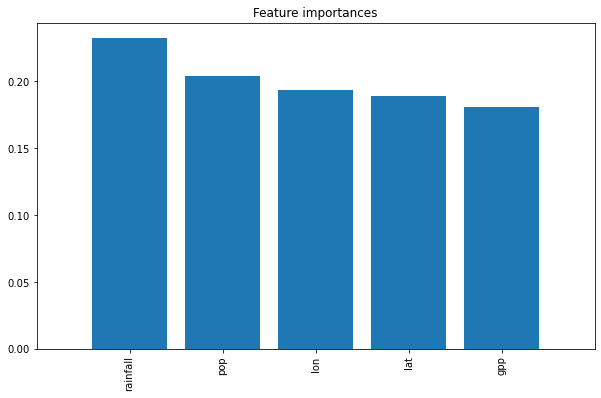

In [29]:
importances = rf.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]
# sort features by importance
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for i in range(X_train.shape[1]):
    print(f"{i+1}. feature {feature_names[indices[i]]} ({importances[indices[i]]})")

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


In [ ]:
sample_size = 2000  # 你可以选择一个较小的样本集来计算 SHAP 值
sample_indices = np.random.choice(X_test.shape[0], sample_size, replace=False)
X_sample = X_test.iloc[sample_indices]
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_sample)

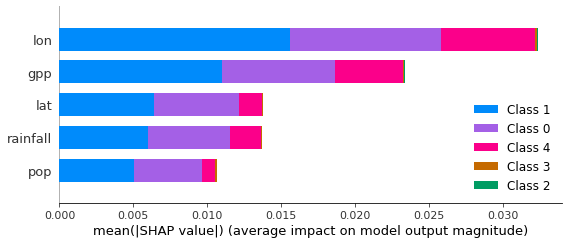

In [32]:
shap.summary_plot(shap_values, X_test)

In [ ]:
# # lime explainer

# import lime
# from lime.lime_tabular import LimeTabularExplainer

# X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
# X_test = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

# explainer = LimeTabularExplainer(X_train, 
#                                  training_labels=y_train, 
#                                  mode='classification',
#                                  feature_names=['lat','lon','gpp','pop','rainfall'],
#                                  class_names=[0,1,2,3,4])

# # sample to explain
# i = 1607 
# explanation = explainer.explain_instance(X_test[i], rf.predict_proba)

# explanation.as_pyplot_figure()